# **Conway's Game of Life**

Le Jeu de la Vie, créé par le mathématicien britannique John Conway en 1970, est un automate cellulaire qui simule l'évolution d'une population de cellules sur une grille bidimensionnelle. Malgré sa simplicité, ce "jeu" sans joueur produit des comportements émergents fascinants et constitue un exemple classique de système complexe. Chaque cellule peut être dans deux états : vivante (1) ou morte (0), et son état futur est déterminé par quatre règles simples basées sur le nombre de voisins vivants dans son voisinage immédiat (les 8 cellules adjacentes) :

*   **Sous-population :** Une cellule vivante avec moins de 2 voisins vivants meurt
*   **Survie :** Une cellule vivante avec 2 ou 3 voisins vivants survit
*   **Surpopulation :** Une cellule vivante avec plus de 3 voisins vivants meurt
*   **Naissance :** Une cellule morte avec exactement 3 voisins vivants devient vivante

# **Notre objectif**

Ce projet explore l'application de différents modèles pour prédire l'évolution du Jeu de la Vie, en suivant deux approches complémentaires :

1.   **Prédiction par pixel/environnement local :** Notre objectif principal est d'entraîner plusieurs modèles (Régression Logistique, KNN, Random Forest, et Réseau de Neurones) à prédire l'état futur d'une cellule individuelle en fonction de son environnement immédiat (son état actuel et ses 8 voisins). Cette approche permet d'évaluer la capacité des modèles à apprendre les règles déterministes de Conway à partir de données d'entraînement, sans connaissance explicite des règles.
2.   **Prédiction de grille complète :** Au-delà de la prédiction cellule par cellule, nous visons à appliquer ces modèles sur des grilles entières pour simuler plusieurs générations successives. Cela permettra d'évaluer la robustesse des modèles lorsqu'ils sont appliqués de manière itérative, où chaque prédiction influence les prédictions suivantes, et de comparer leur performance avec l'implémentation algorithmique classique basée sur les règles.


# **Librairie**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image
from IPython.display import display, clear_output
import time
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# **Implémentation du jeu de la vie**

**Rules of Conway's Game of Life**
*   Si une cellule a exactement trois voisines vivantes, elle est vivante à l’étape suivante.
*   Si une cellule a exactement deux voisines vivantes, elle reste dans son état actuel à l’étape suivante.
*   Si une cellule a strictement moins de deux ou strictement plus de trois voisines vivantes, elle est morte à l’étape suivante.

**game implementation parameters :**

In [2]:
GRID_SIZE = 50
EPOCH = 100
INTERVAL = 200

In [3]:
def random_grid(size):
  return np.random.randint(0, 2, size=(size, size))

In [4]:
def count_neighbours(grid):
  # On définit un noyau (filtre) :
  # 1 partout (pour compter le voisin)
  # 0 au centre (on ne se compte pas soi-même)
  kernel = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

  return convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

In [5]:
def next_state(grid):
  next_grid = np.zeros(grid.shape, dtype=int)
  neighbours = count_neighbours(grid)
  next_grid[neighbours == 3] = 1
  next_grid[neighbours == 2] = grid[neighbours == 2]
  return next_grid

In [6]:
def plot_grid(grid, epoch=0):
  plt.imshow(grid, cmap='binary')
  plt.title(f"Jeu de la Vie - Époque {epoch}", fontsize=16)
  plt.axis('off')
  plt.show()

In [7]:
def simulate(grid, epoch, white_bg=False):
  print("Jeu de la vie - Simulation en cours ...")
  text_handle = None
  display_handle = None

  for i in range(epoch) :
    if white_bg:
      img_array = ((1 - grid) * 255).astype('uint8')
    else :
      img_array = (grid * 255).astype('uint8')

    img = Image.fromarray(img_array)
    img = img.convert('L')
    img = img.resize((400, 400), Image.NEAREST)

    label = f"Génération : {i + 1} / {epoch}"

    # Afficher ou mettre à jour
    if i == 0:
      text_handle = display(label, display_id=True)
      display_handle = display(img, display_id=True)
    else:
      text_handle.update(label)
      display_handle.update(img)

    grid = next_state(grid)
    time.sleep(INTERVAL / 1000)
  print("Simulation terminée!")

Jeu de la vie - Simulation en cours ...


'Génération : 100 / 100'

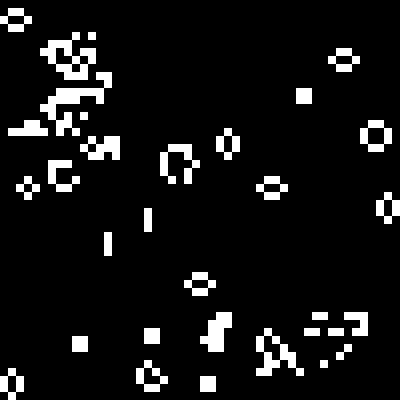

Simulation terminée!


In [ ]:
grid = random_grid(GRID_SIZE)
simulate(grid, EPOCH)

# **Statistique Descriptive**

**génération des données**

In [47]:
def generate_pixel_data(data_size):
  data = []
  label =  []

  for _ in range(data_size):
    input_grid = random_grid(PIXEL_GRID_SIZE)
    parameters = get_parameters(input_grid)
    data.append(parameters)
    label.append(cell_next_state(input_grid))

  df = pd.DataFrame({
      'data' : data,
      'label' : label
  })

  return df, data, label

**génération d'un dataframe**

In [49]:
# Génération des données
data_size = 10000
df, data, label = generate_pixel_data(data_size)

# Extraction des paramètres dans des colonnes séparées (8 colonnes seulement)
df_expanded = pd.DataFrame(data, columns=[
    'neighbor_0', 'neighbor_1', 'neighbor_2', 'neighbor_3',
    'neighbor_4', 'neighbor_5', 'neighbor_6', 'neighbor_7'
])
df_expanded['label'] = label

print(f"DataFrame créé avec {len(df_expanded)} lignes")
print(df_expanded.head())

DataFrame créé avec 10000 lignes
   neighbor_0  neighbor_1  neighbor_2  neighbor_3  neighbor_4  neighbor_5  \
0           0           1           0           0           0           1   
1           0           1           0           0           1           0   
2           1           0           0           1           1           1   
3           1           1           1           0           1           0   
4           1           1           1           0           0           1   

   neighbor_6  neighbor_7  label  
0           0           0      1  
1           0           0      1  
2           0           1      0  
3           0           1      0  
4           1           0      0  


**statistique descriptive**

In [50]:
# Statistiques générales
print("=== STATISTIQUES DESCRIPTIVES ===\n")
print(df_expanded.describe())

# Distribution des labels
print("\n=== DISTRIBUTION DES LABELS ===")
print(df_expanded['label'].value_counts())
print(f"\nProportion de cellules vivantes : {df_expanded['label'].mean():.2%}")

# Statistiques par label
print("\n=== STATISTIQUES PAR ÉTAT FUTUR ===")
print(df_expanded.groupby('label').describe().T)

=== STATISTIQUES DESCRIPTIVES ===

         neighbor_0    neighbor_1    neighbor_2    neighbor_3    neighbor_4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.504900      0.501300      0.503600      0.504300      0.502000   
std        0.500001      0.500023      0.500012      0.500007      0.500021   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         neighbor_5    neighbor_6    neighbor_7         label  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.492100      0.500000      0.498300      0.268600  
std        0.499963      0.500025      0.500022      0.443254

**visualisation des distributions**

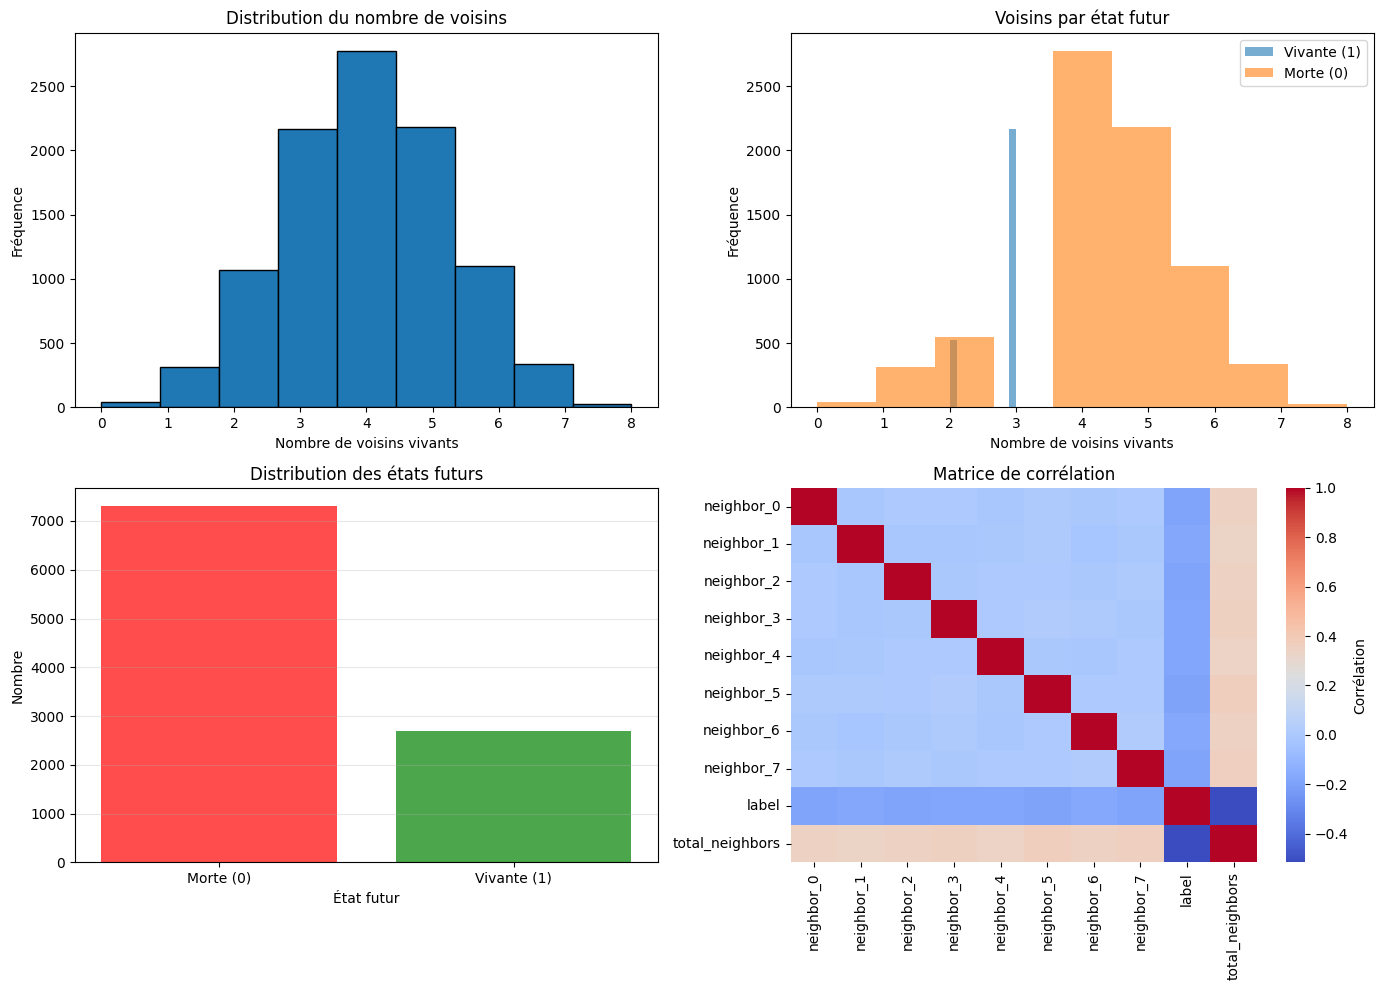

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution des voisins vivants
neighbor_cols = [f'neighbor_{i}' for i in range(8)]
df_expanded['total_neighbors'] = df_expanded[neighbor_cols].sum(axis=1)

axes[0, 0].hist(df_expanded['total_neighbors'], bins=9, edgecolor='black')
axes[0, 0].set_xlabel('Nombre de voisins vivants')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution du nombre de voisins')

# Distribution par label
for label_val in df_expanded['label'].unique():
    subset = df_expanded[df_expanded['label'] == label_val]
    axes[0, 1].hist(subset['total_neighbors'], alpha=0.6, bins=9,
                    label=f"{'Vivante' if label_val == 1 else 'Morte'} ({label_val})")
axes[0, 1].set_xlabel('Nombre de voisins vivants')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Voisins par état futur')
axes[0, 1].legend()

# Distribution des labels (remplace État actuel vs futur)
label_counts = df_expanded['label'].value_counts()
axes[1, 0].bar(['Morte (0)', 'Vivante (1)'], label_counts.values, color=['red', 'green'], alpha=0.7)
axes[1, 0].set_xlabel('État futur')
axes[1, 0].set_ylabel('Nombre')
axes[1, 0].set_title('Distribution des états futurs')
axes[1, 0].grid(axis='y', alpha=0.3)

# Matrice de corrélation
correlation = df_expanded.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', ax=axes[1, 1],
            cbar_kws={'label': 'Corrélation'})
axes[1, 1].set_title('Matrice de corrélation')

plt.tight_layout()
plt.show()

**Distribution du nombre de voisins:**

La distribution forme une courbe en cloche centrée sur 3-4 voisins, typique d'une génération aléatoire. Les cas extrêmes (0 ou 8 voisins) sont très rares, tandis que les configurations avec 3-5 voisins dominent avec 2000-2700 occurrences chacune. Cela confirme que nos données sont bien générées aléatoirement et représentent toutes les configurations possibles du Jeu de la Vie.

**voisins par états futur:**

Ce graphique montre une séparation claire entre les deux classes, conforme aux règles de Conway. Les cellules vivantes (bleu) présentent un pic net à 3 voisins (règle de naissance), tandis que les cellules mortes (orange) dominent à 0-2 voisins (sous-population) et 4-8 voisins (surpopulation). La faible superposition des courbes indique que le problème de classification sera relativement facile pour nos modèles.

**distributions des états futurs :**

Le dataset présente un déséquilibre avec ~72% de cellules mortes contre ~28% de cellules vivantes (ratio 2.7:1). Ce déséquilibre est naturel dans le Jeu de la Vie où la majorité des configurations mènent à la mort. Bien que notable, ce ratio reste acceptable pour l'entraînement et reflète la réalité du système modélisé.

**Matrice de corrélations :**

Les corrélations entre voisins sont très faibles (zones bleues), ce qui signifie que chaque voisin apporte une information unique sans redondance. La variable total_neighbors montre la corrélation la plus forte avec le label (zone rouge en bas à droite), confirmant qu'elle est le facteur prédictif le plus important. L'indépendance des features est idéale pour la performance des modèles de classification.

In [53]:
# Tableau croisé : nombre de voisins × état futur
print("\n=== ANALYSE PAR RÈGLES DU JEU DE LA VIE ===")
cross_tab = pd.crosstab(
    df_expanded['total_neighbors'],
    df_expanded['label'],
    normalize='index'
)
cross_tab.columns = ['Meurt/Reste morte (0)', 'Naît/Survit (1)']
cross_tab.index.name = 'Nombre de voisins'
print(cross_tab.round(3))

# Vérification des règles de Conway
print("\n=== VÉRIFICATION DES RÈGLES ===")
print("Règle attendue : cellule vivante avec 2-3 voisins OU cellule morte avec 3 voisins → 1")
print("Sinon → 0")


=== ANALYSE PAR RÈGLES DU JEU DE LA VIE ===
                   Meurt/Reste morte (0)  Naît/Survit (1)
Nombre de voisins                                        
0                                   1.00             0.00
1                                   1.00             0.00
2                                   0.51             0.49
3                                   0.00             1.00
4                                   1.00             0.00
5                                   1.00             0.00
6                                   1.00             0.00
7                                   1.00             0.00
8                                   1.00             0.00

=== VÉRIFICATION DES RÈGLES ===
Règle attendue : cellule vivante avec 2-3 voisins OU cellule morte avec 3 voisins → 1
Sinon → 0


Cette analyse croisée confirme parfaitement que les données respectent les règles classiques du Jeu de la Vie de Conway :

*   0-1 voisins : 100% des cellules meurent ou restent mortes (sous-population)
*   2 voisins : 49% survivent (uniquement si la cellule était déjà vivante), 51% meurent (règle de stase)
*   3 voisins : 100% des cellules deviennent ou restent vivantes (règle magique de naissance/survie)
*   4-8 voisins : 100% des cellules meurent ou restent mortes (surpopulation)

Le seul cas où les deux états coexistent est à 2 voisins (distribution presque 50/50), ce qui correspond exactement à la règle de survie : une cellule déjà vivante survit avec 2 voisins, mais une cellule morte ne naît pas. Cette analyse valide que notre générateur de données implémente correctement les règles de Conway et que nos modèles devront apprendre ces transitions d'états spécifiques.

# **Analyse par pixel**

- essayer plusieurs algos (régression, kppv, random forest)
- faire une analyse par image (déjà fait par notre modèle)
- faire une analyse par pixel (voir photos), le modèle de scoring est fait sur ce modèle
- comparer les deux techniques

L'objectif est de déterminer l'état d'un pixel $p$ à la génération suivante en fonction de son voisinage immédiat. Ce voisinage, de type Moore, comprend les 8 pixels adjacents (3 supérieurs, 3 inférieurs et 2 latéraux). Ces 8 états constituent les paramètres d'entrée de notre modèle de scoring, lequel repose sur une variable binaire : 1 pour un pixel vivant et 0 pour un pixel mort. Nous présentons le graphe ci dessous pour illustrer notre ensemble d'étude :

In [8]:
PIXEL_GRID_SIZE = 3

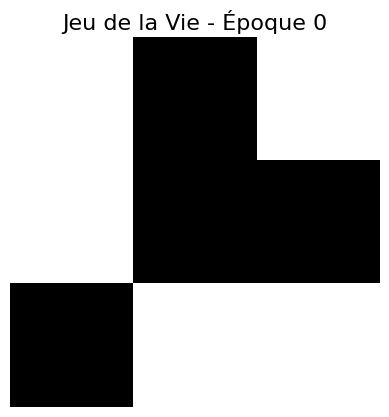

In [9]:
pixel_grid = random_grid(PIXEL_GRID_SIZE)
plot_grid(pixel_grid)

Nous obtenons pour une grille donnée, la liste de paramètre suivant :

In [10]:
def get_parameters(grid):
  """
  Permet d'obtenir les 8 paramètres (voisins) d'un pixel donné.
  """
  f_grid = grid.flatten()
  parameters = np.delete(f_grid, 4)
  return parameters

print(get_parameters(pixel_grid))

[0 1 0 0 1 1 0 0]


In [11]:
def cell_next_state(grid):
  """
  Permet d'obtenir l'état suivant de la cellule que l'on étudie
  """
  next_grid = next_state(grid)
  return next_grid.flatten()[4]

## **Génération d'un dataset**

**dataset parameters**

In [12]:
TRAINING_SIZE_PIXEL = 3000
TEST_SIZE_PIXEL = 1000
VAL_SIZE_PIXEL = 1000

**dataset hyperparameters**

In [13]:
batch_size_pixel=64

**génération des données d'entrainements :**

In [14]:
def generate_pixel_data(data_size):
  data = []
  label =  []

  for _ in range(data_size):
    input_grid = random_grid(PIXEL_GRID_SIZE)
    parameters = get_parameters(input_grid)
    data.append(parameters)
    label.append(cell_next_state(input_grid))

  df = pd.DataFrame({
      'data' : data,
      'label' : label
  })

  return df, data, label

In [15]:
train_pixel_df, X, y = generate_pixel_data(TRAINING_SIZE_PIXEL)
test_pixel_df, X_test, y_test = generate_pixel_data(TEST_SIZE_PIXEL)
val_pixel_df, X_val, y_val = generate_pixel_data(VAL_SIZE_PIXEL)

**implémentation d'un dataset**

In [16]:
class pixel_dataset(Dataset) :
  def __init__(self, data, label):
    self.data = data
    self.label = label

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = torch.tensor(self.data[index], dtype=torch.float32)
    y = torch.tensor(self.label[index], dtype=torch.float32)
    return x, y

In [17]:
train_pixel_dataset = pixel_dataset(
    train_pixel_df['data'],
    train_pixel_df['label'])

test_pixel_dataset = pixel_dataset(
    test_pixel_df['data'],
    test_pixel_df['label'])

val_pixel_dataset = pixel_dataset(
    val_pixel_df['data'],
    val_pixel_df['label'])

## **Préparation des métrique d'évaluation**

Dans le cadre de notre prédiction, nous proposons plusieurs solutions:
*   régression
*   kppv
*   random forest
*   MLP

Nous évaluons ces modèles avec les métriques precision, recall et matrice de confusions

In [18]:
def get_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)
  conf_mat = confusion_matrix(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  return precision, recall, conf_mat

In [19]:
def plot_roc(model, X_test, y_test):
  y_scores = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
  RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  plt.show()

## **Regression**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, roc_curve, auc, RocCurveDisplay)

In [21]:
max_iter = 2000
proba = 0.5
logistic_model = LogisticRegression(max_iter=max_iter,
                         random_state=0,
                         class_weight='balanced').fit(X, y)

# Calcul de la matrice de confusion et des scores de précisions et de rappel :
logistic_precision, logistic_recall, logistic_conf_mat = get_metrics(logistic_model, X_test, y_test)

print("couple précision-rappel :")
print(f"Précision : {logistic_precision}")
print(f"Rappel : {logistic_recall}")

couple précision-rappel :
Précision : 0.7181818181818181
Rappel : 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


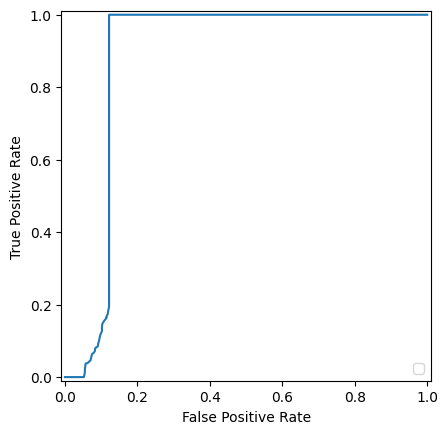

In [22]:
plot_roc(logistic_model, X_test, y_test)

## **KPPV**

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
# Normalisation des données :
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y)

In [25]:
KNN_precision, KNN_recall, KNN_conf_mat = get_metrics(knn_model, X_test_scaled, y_test)

print("couple précision-rappel :")
print(f"Précision : {KNN_precision}")
print(f"Rappel : {KNN_recall}")

couple précision-rappel :
Précision : 0.9067796610169492
Rappel : 0.9029535864978903


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


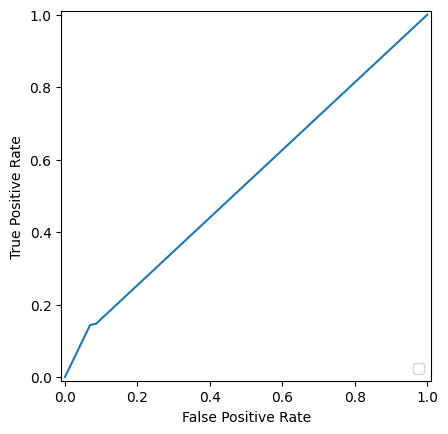

In [26]:
plot_roc(knn_model, X_test, y_test)

## **Random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
RF_model = RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0).fit(X, y)
RF_precision, RF_recall, RF_conf_mat = get_metrics(RF_model, X_test, y_test)

print("couple précision-rappel :")
print(f"Précision : {RF_precision}")
print(f"Rappel : {RF_recall}")

couple précision-rappel :
Précision : 0.53
Rappel : 0.8945147679324894


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


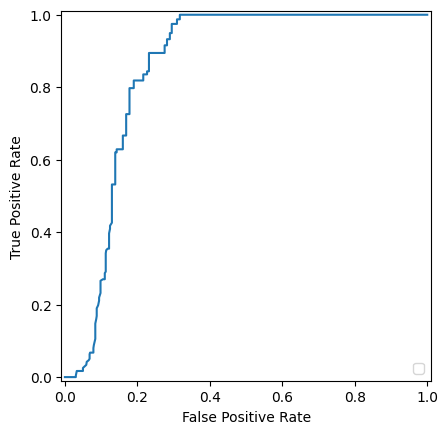

In [29]:
plot_roc(RF_model, X_test, y_test)

## **Réseau de Neuronne**

In [37]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(8, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 1),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [38]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

neural_network_model = NeuralNetwork().to(device)
print(neural_network_model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [45]:
# Préparation des données pour PyTorch
X_train_tensor = torch.FloatTensor(X).to(device)
y_train_tensor = torch.FloatTensor(y).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Configuration de l'entraînement
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neural_network_model.parameters(), lr=0.001)
epochs = 100

# Entraînement
for epoch in range(epochs):
    neural_network_model.train()
    optimizer.zero_grad()
    pred = neural_network_model.forward(X_train_tensor)
    loss = loss_fn(pred.squeeze(1), y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 20/100, Loss: 0.4208
Epoch 40/100, Loss: 0.2872
Epoch 60/100, Loss: 0.1949
Epoch 80/100, Loss: 0.1340
Epoch 100/100, Loss: 0.0981


couple précision-rappel :
Précision : 0.0
Rappel : 0.0

Matrice de confusion :
[[419 344]
 [237   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


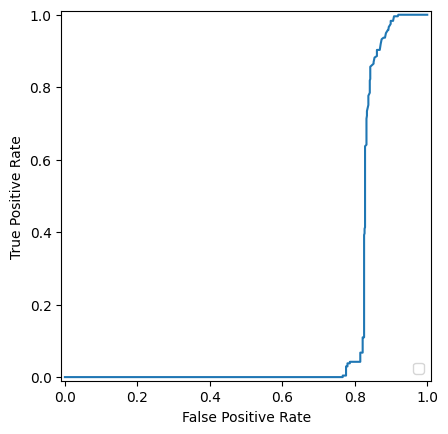

In [46]:
class NN_eval:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            logits = self.model.forward(X_tensor)
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).float().cpu().numpy().flatten()
        return predictions

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            logits = self.model.forward(X_tensor)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
        return np.column_stack([1-probs, probs])

# Wrapper du modèle
nn_eval = NN_eval(neural_network_model, device)

# Métriques
NN_precision, NN_recall, NN_conf_mat = get_metrics(nn_eval, X_test_scaled, y_test)
print("couple précision-rappel :")
print(f"Précision : {NN_precision}")
print(f"Rappel : {NN_recall}")
print(f"\nMatrice de confusion :\n{NN_conf_mat}")
plot_roc(nn_eval, X_test_scaled, y_test)

# **Analyse Par Image**

## **Génération d'un dataset**

**dataset parameters :**

In [ ]:
TRAINING_SIZE = 3000
TEST_SIZE = 1000
VAL_SIZE = 1000

**dataset hyperparameters**

In [ ]:
batch_size = 64

**génération des données d'entrainement, test et validation :**

In [ ]:
def generate_data(grid_size, data_size) :
  data = []
  label = []

  for i in range(data_size):
    input_grid = random_grid(grid_size)
    data.append(input_grid)
    label_grid = next_state(input_grid)
    label.append(label_grid)

  df = pd.DataFrame({
      'data' : data,
      'label' : label
  })

  return df

In [ ]:
train_df = generate_data(GRID_SIZE, TRAINING_SIZE)
test_df = generate_data(GRID_SIZE, TEST_SIZE)
val_df = generate_data(GRID_SIZE, VAL_SIZE)

**implémentation d'un dataset**

In [ ]:
class gol_dataset(Dataset) :
  def __init__(self, data, label):
    self.data = data
    self.label = label

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = torch.tensor(self.data[index], dtype=torch.float32)
    y = torch.tensor(self.label[index], dtype=torch.float32)
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    return x, y

In [ ]:
train_dataset = gol_dataset(train_df['data'], train_df['label'])
test_dataset = gol_dataset(test_df['data'], test_df['label'])
val_dataset = gol_dataset(val_df['data'], val_df['label'])

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"train shape : {train_features[0].shape}")
print(f"label shape : {train_labels[0].shape}")

Feature batch shape: torch.Size([64, 1, 50, 50])
Labels batch shape: torch.Size([64, 1, 50, 50])
train shape : torch.Size([1, 50, 50])
label shape : torch.Size([1, 50, 50])


## **Implémentation d'un réseau de neuronne**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

**hyperpameters :**

In [ ]:
lr = 0.001
momentum = 0.9
epochs = 150

**Define a CNN**

In [ ]:
class GOL_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # --- Étape 1 : Ouverture (1 -> 32 canaux) ---
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(32) # Toujours après une conv

    # --- Étape 2, 3, 4 : Le Corps (32 -> 32 canaux) ---
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn3   = nn.BatchNorm2d(32)

    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn4   = nn.BatchNorm2d(32)

    # --- Étape 5 : Fermeture / Tête (32 -> 1 canal) ---
    self.head = nn.Conv2d(32, 1, kernel_size=1)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))

    x = self.head(x)

    return x

In [ ]:
gol_cnn = GOL_CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gol_cnn.to(device)

GOL_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

**Define a Loss function and an optimizer**

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(gol_cnn.parameters(), lr=lr, momentum=momentum)

**Train the network :**

In [ ]:
train_losses = []
test_losses = []
test_accuracies = []

loop = tqdm(range(epochs), desc="Training")

for epoch in loop:
  gol_cnn.train()
  running_train_loss = 0.0

  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = gol_cnn(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

  # Calcul de la perte moyenne pour cette époque
  avg_train_loss = running_train_loss / len(train_dataloader)
  train_losses.append(avg_train_loss)

  # --- PHASE DE TEST / VALIDATION ---
  gol_cnn.eval()  # Active le mode évaluation
  running_test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = gol_cnn(inputs)
      predicted = (outputs.data > 0.5).float()
      loss = criterion(predicted, labels)
      running_test_loss += loss.item()

      total += labels.numel() # Nombre total de cellules (pixels)
      correct += (predicted == labels).sum().item()

  avg_test_loss = running_test_loss / len(test_dataloader)
  accuracy = 100 * correct / total

  test_losses.append(avg_test_loss)
  test_accuracies.append(accuracy)

  # Mise à jour de la barre tqdm
  loop.set_postfix(loss_train=f"{avg_train_loss:.4f}", loss_test=f"{avg_test_loss:.4f}", acc=f"{accuracy:.2f}%")

print('Finished Training')

Training:   3%|▎         | 4/150 [02:47<1:41:52, 41.87s/it, acc=71.26%, loss_test=0.6958, loss_train=0.4647]


KeyboardInterrupt: 

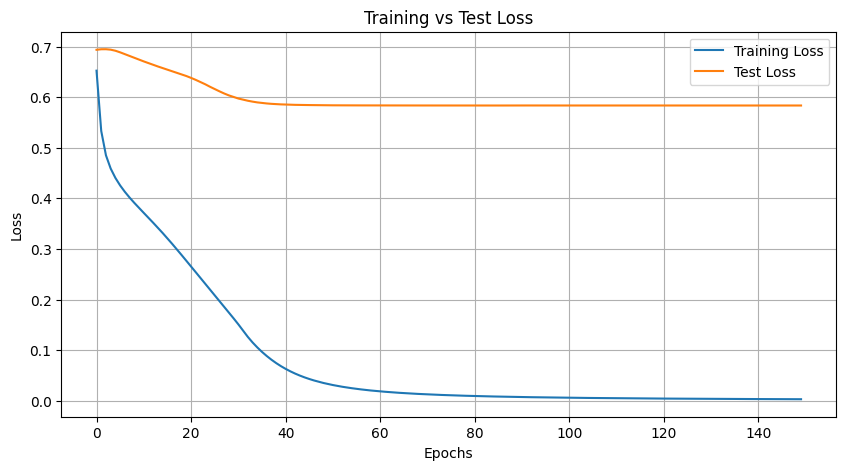

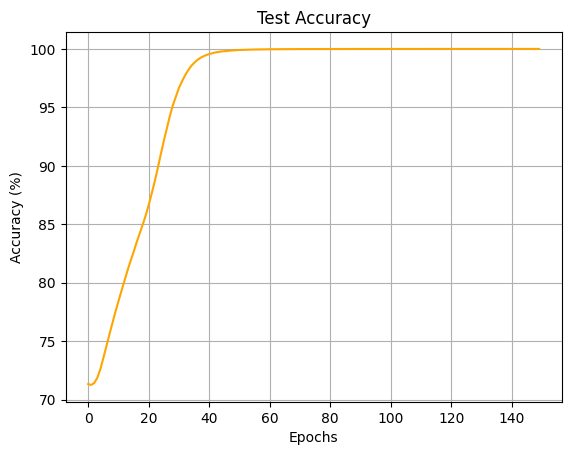

In [ ]:
# --- GRAPHIQUE DES PERTES ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

## **Visualisation**

In [ ]:
def grid_accuracy(outputs, targets) :
  predicted = (outputs > 0.5).float()
  total = predicted.numel()
  correct = (predicted.cpu() == targets).float().sum()
  return (correct / total).item()

accuracy :  1.0
prediction


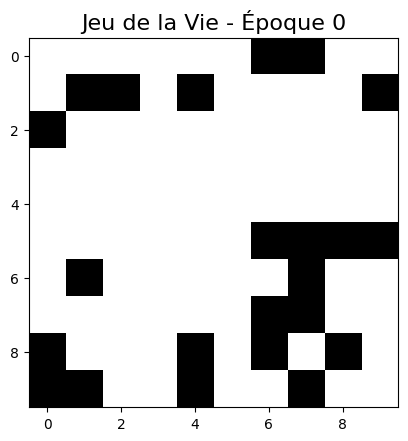

output


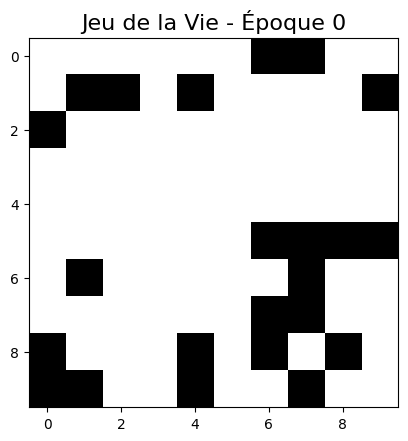

In [ ]:
r_grid = random_grid(10)
n_grid = next_state(r_grid)
r_grid = torch.tensor(r_grid, dtype=torch.float32)
r_grid = r_grid.unsqueeze(0)
r_grid = r_grid.unsqueeze(0)
r_grid = r_grid.to(device)

with torch.no_grad():
  outputs = gol_cnn(r_grid)

print("accuracy : ", grid_accuracy(outputs, n_grid))
predicted = (outputs.data > 0.5).float()
print("prediction")
plot_grid(predicted.squeeze(0).squeeze(0).cpu())
print("output")
plot_grid(n_grid)

In [ ]:
def simulate_and_predict(model, grid_size=10, epochs=20, white_bg=False):
    """
    Simule le jeu de la vie et prédit l'état après N époques
    Affiche la simulation à gauche
    """
    print("=== Simulation et Prédiction ===")
    print(f"Grille initiale : {grid_size}x{grid_size}")
    print(f"Nombre d'époques : {epochs}\n")

    # Génération de la grille initiale
    initial_grid = random_grid(grid_size)
    current_grid = initial_grid.copy()

    # Prédiction avec le modèle
    print("\nCalcul de la prédiction avec le modèle...")
    grid_tensor = torch.tensor(initial_grid, dtype=torch.float32)
    grid_tensor = grid_tensor.unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_grid = grid_tensor
        for _ in range(epochs):
            pred_grid = model(pred_grid)
            pred_grid = (pred_grid > 0.5).float()

    predicted_final = pred_grid.squeeze(0).squeeze(0).cpu().numpy()
    if white_bg:
      img_pred = ((1 - predicted_final) * 255).astype('uint8')
    else:
      img_pred = (predicted_final * 255).astype('uint8')
    img_pred = Image.fromarray(img_pred)
    img_pred = img_pred.convert('L')
    img_pred = img_pred.resize((400, 400), Image.NEAREST)

    # Simulation visuelle
    print("Simulation du jeu de la vie...")
    text_handle = None
    display_handle = None
    text_handle_pred = None
    display_handle_pred = None

    for i in range(epochs + 1):
        if white_bg:
            img_array = ((1 - current_grid) * 255).astype('uint8')
        else:
            img_array = (current_grid * 255).astype('uint8')

        img = Image.fromarray(img_array)
        img = img.convert('L')
        img = img.resize((400, 400), Image.NEAREST)

        # création d'une image combinée :
        combined_width = 840
        combined_height = 400
        combined_img = Image.new('RGB', (combined_width, combined_height), color='white')

        img_real_rgb = img.convert('RGB')
        img_pred_rgb = img_pred.convert('RGB')

        combined_img.paste(img_real_rgb, (0, 0))
        combined_img.paste(img_pred_rgb, (420, 0))

        label_gen = f"Génération : {i} / {epochs}"
        label_pred = f"Prédiction de la génération {epochs}"

        if i == 0:
            text_handle = display(label_gen, display_id=True)
            display_handle = display(combined_img, display_id=True)
            text_handle_pred = display(label_pred, display_id=True)
        else:
            text_handle.update(label_gen)
            display_handle.update(combined_img)
            text_handle_pred.update(label_pred)

        if i < epochs:
          current_grid = next_state(current_grid)
          time.sleep(INTERVAL / 1000)

    # État final réel
    final_grid_real = current_grid

    # Calcul de l'accuracy
    accuracy = grid_accuracy(
        torch.tensor(predicted_final).unsqueeze(0).unsqueeze(0),
        final_grid_real
    )

    print(f"\nSimulation terminée!")
    print(f"Accuracy de la prédiction : {accuracy * 100:.2f}%")

    return initial_grid, final_grid_real, predicted_final, accuracy

=== Simulation et Prédiction ===
Grille initiale : 10x10
Nombre d'époques : 10


Calcul de la prédiction avec le modèle...
Simulation du jeu de la vie...


'Génération : 10 / 10'

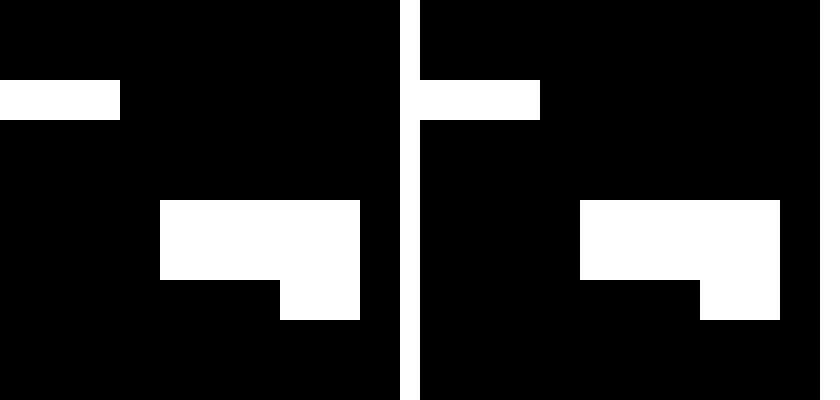

'Prédiction de la génération 10'


Simulation terminée!
Accuracy de la prédiction : 100.00%


In [ ]:
# Exécution
initial, real_final, pred_final, acc = simulate_and_predict(
    model=gol_cnn,
    grid_size=10,
    epochs=10,
    white_bg=False
)

# **References**



*   [Recommending Training Set Sizes for Classification](https://arxiv.org/pdf/2102.09382)

